In [2]:
# Donald Nguyen
# Created 09/28/2021

%load_ext autoreload
%autoreload 2
# Imports
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits

from wavelength import air2vac, vac2air, relativistic_rv_shift
from fits_loader import FitsFileLoader
from vels_loader import VelsLoader_CCF
from line_list_loader import LineListLoader_Wise
from line_list_loader import LineListLoader_VALD

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load fits files and vels/ccf files
loader = FitsFileLoader()
vloader = VelsLoader_CCF('34411')

# Create list of ndarrays and velocities for each fits file
datas = [loader.data_from_single_fits(filepath, 1) for filepath in loader.filepaths]
vels = [vloader.velocity_from_fits(filename) for filename in loader.filenames]
assert(len(datas) == len(vels))
rv_shifts = [relativistic_rv_shift(vel['v']) for vel in vels]

# Create list of pd.Series of rv corrected wavelengths, continuums, and spectra for each fits file
#   vels[0]['units'] = 'cm/s'
wavelengths = [datas[i]['bary_wavelength'] * rv_shifts[i] for i in np.arange(len(datas))]
continuums = [data['continuum'] for data in datas]
spectra = [data['spectrum'] for data in datas]

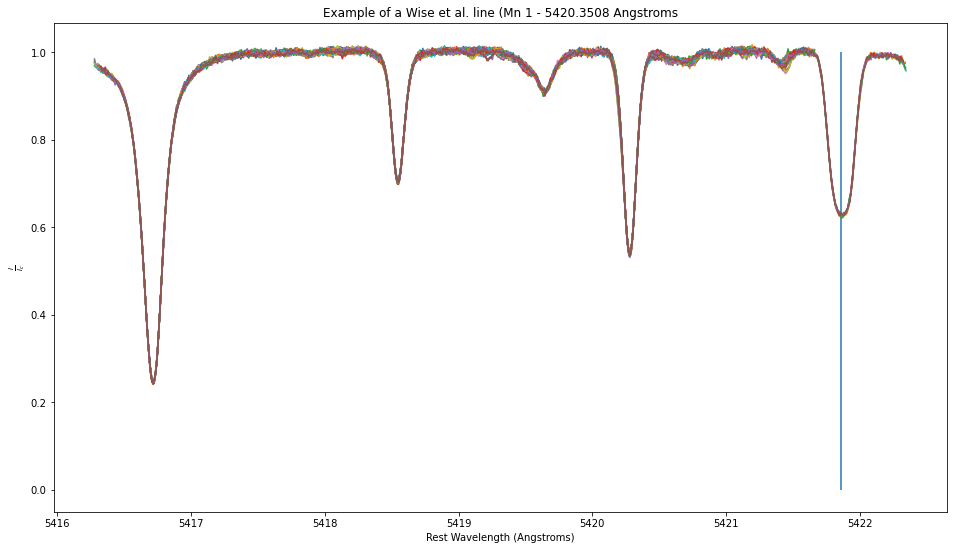

In [4]:
# Example plot of a Wise et al. line (Mn 1 5420.3508 A)
obs_ex = []
order_ex = 47
obs_range_ex = (3500, 4000)
for i in range(len(wavelengths)):
    obs_ex.append(spectra[i][order_ex, obs_range_ex[0]:obs_range_ex[1]] / continuums[i][order_ex, obs_range_ex[0]:obs_range_ex[1]])

plt.figure(figsize=(16, 9))
for wavelength, ob in zip(wavelengths, obs_ex):
    plt.plot(wavelength[order_ex, obs_range_ex[0]:obs_range_ex[1]], ob)
plt.vlines(air2vac(5420.3508), 0, 1)
plt.title('Example of a Wise et al. line (Mn 1 - 5420.3508 Angstroms')
plt.xlabel('Rest Wavelength (Angstroms)')
plt.ylabel(r'$\frac{I}{I_c}$')
plt.show()

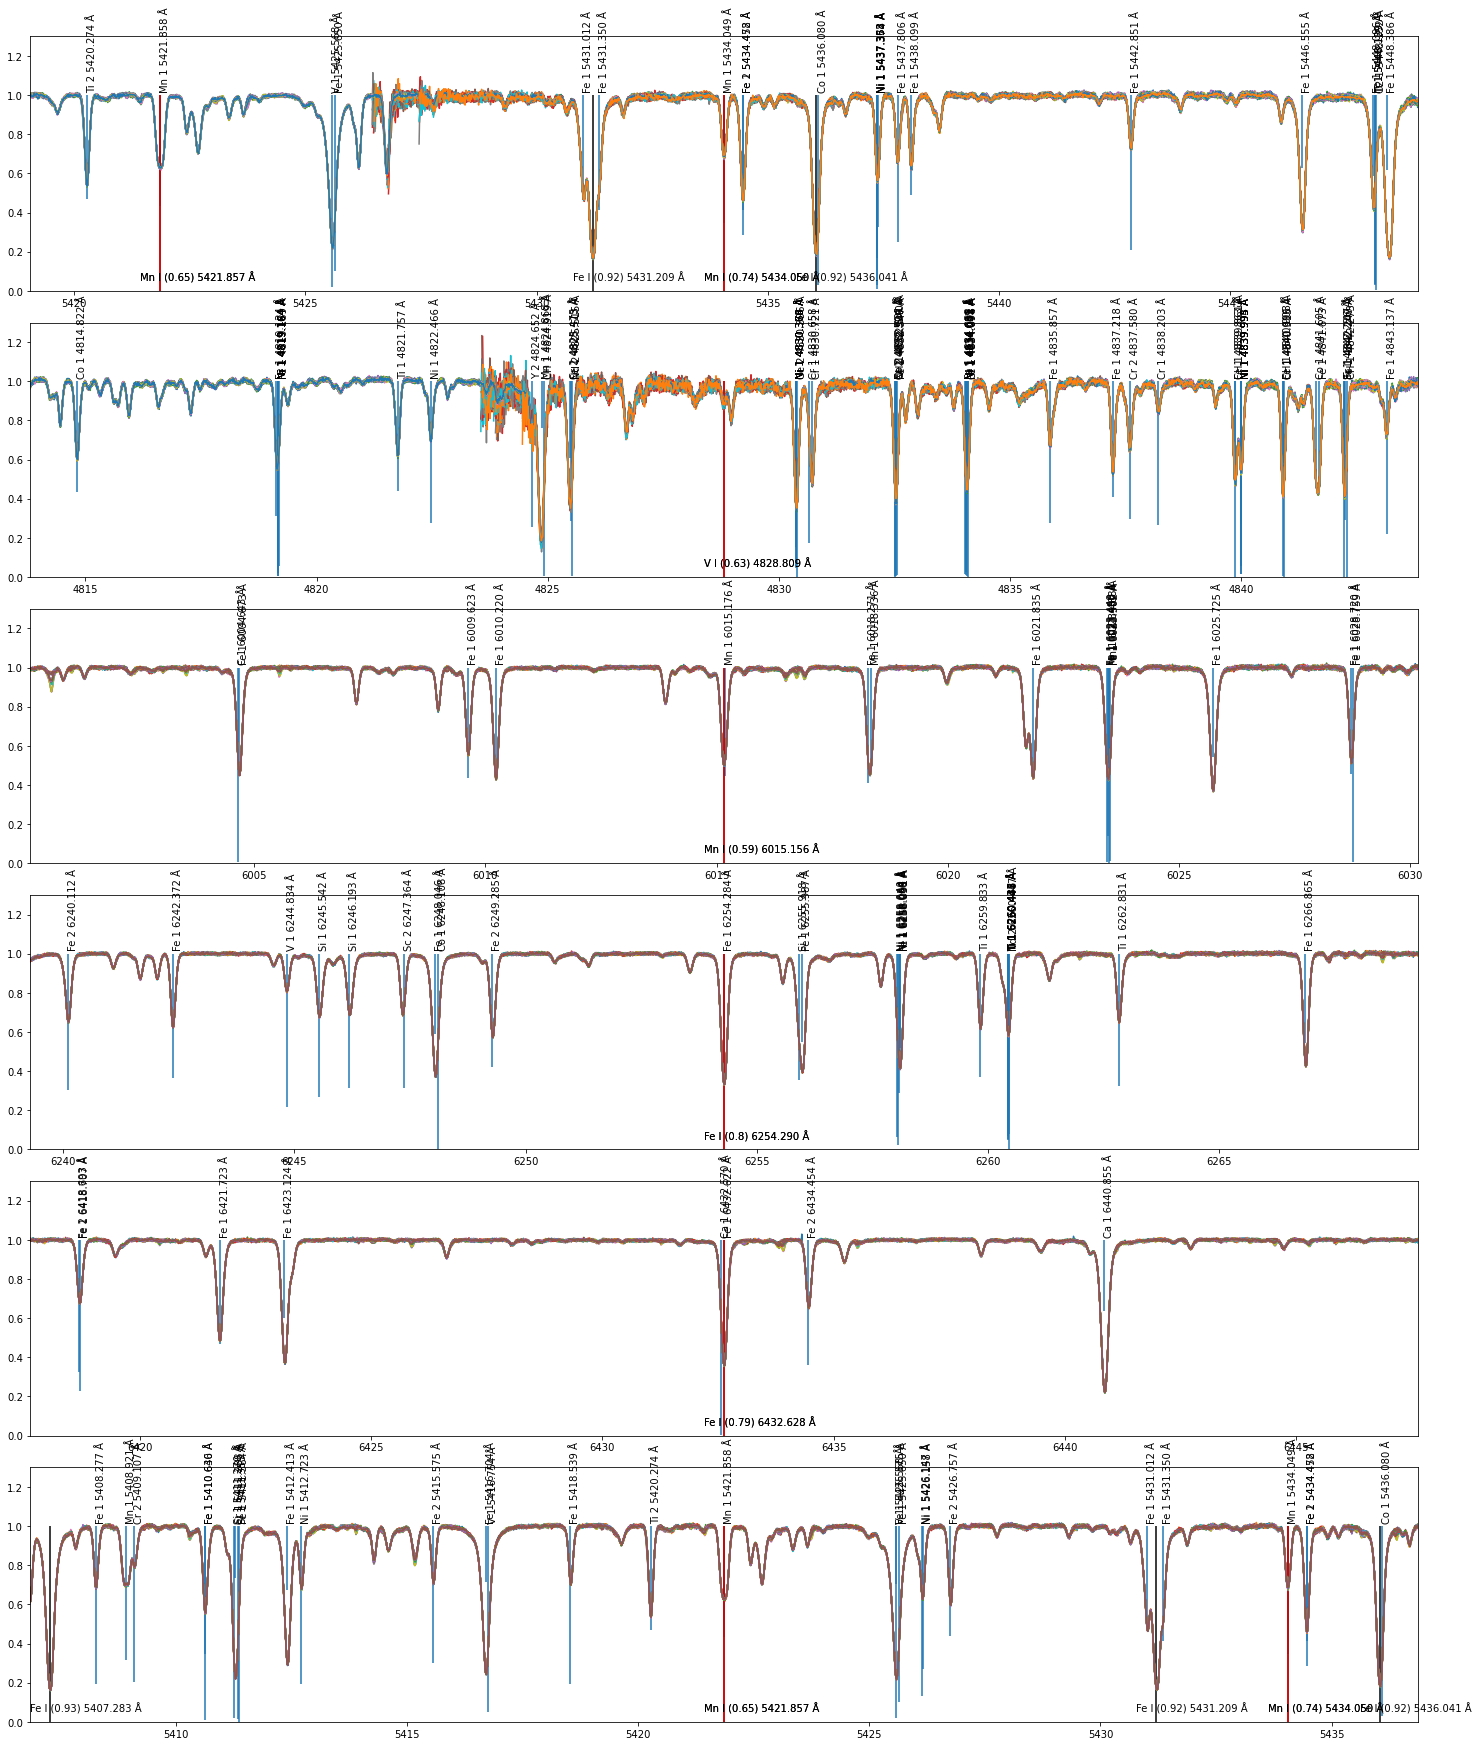

In [5]:
from scipy.interpolate import interp1d                            

wise_lines = LineListLoader_Wise()

# We choose the Wise lines to be the ones that are within the VALD depth range
# The depth range of 0.5 to 0.8 is to avoid deep Fe lines that have broadening
min_VALD_depth = 0.5
max_VALD_depth = 0.8
chosen_wise_lines = wise_lines.list_VALD_depths(min_VALD_depth, max_VALD_depth)
# print(chosen_wise_lines)


# All VALD lines
vald_lines = LineListLoader_VALD().dataframe

# List of observed intensities
obs = [spectra[i] / continuums[i] for i in np.arange(len(wavelengths))]

# For the chosen Wise et al. lines, query the file's index (in datas list) and order that contains that line
# chosen_wise_lines_positions will contain { 'line': [(index, order), (index2, order2)], ... }
chosen_wise_lines_positions = {}
for chosen_line in chosen_wise_lines['Wavelength']: # Wavelengths in air
    chosen_wise_lines_positions[chosen_line] = []
    for ind_file, (wavelength, ob) in enumerate(zip(wavelengths, obs)):
        for order in np.arange(len(wavelength)):
            if wavelength[order, 0] <= air2vac(chosen_line) <= wavelength[order, -1]:
                chosen_wise_lines_positions[chosen_line].append((ind_file, order))
            # could interpolate in current file and order to find the observed intensity 
            # at/near the chosen wavelength


# For the chosen Wise lines, we will plot all files and orders that contain them
# We will look +/-wave_range Angstroms around the chosen line to find similarly shaped lines
wave_range = 30

fig, axes = plt.subplots(chosen_wise_lines['Wavelength'].count(), 1, figsize =(20, 24))
plt.tight_layout()
for ax, (chosen_line_index, chosen_line), positions in zip(axes, chosen_wise_lines.iterrows(), chosen_wise_lines_positions.values()):
    chosen_line_vac = air2vac(chosen_line['Wavelength'])

    # Set the axis limits
    lower_xbound = chosen_line_vac - wave_range / 2
    upper_xbound = chosen_line_vac + wave_range / 2
    ax.set_xlim(lower_xbound, upper_xbound)
    ax.set_ylim(0, 1.3)

    # For each file and order, plot the observed spectrum and concatenate into one x and y arrays
    x = np.array([])
    y = np.array([])
    for ind_file, order in positions:
        x = np.concatenate((x, wavelengths[ind_file][order]))
        y = np.concatenate((y, obs[ind_file][order]))
        ax.plot(wavelengths[ind_file][order], obs[ind_file][order])
    
    # Sort the concatenated x and y arrays by x (wavelength) and then interpolate to the chosen line
    grid = np.column_stack((x, y))
    sorted_grid = grid[np.argsort(grid[:, 0])]
    sorted_grid = sorted_grid[~np.isnan(sorted_grid[:, 1])]
    spline = interp1d(grid[:, 0], grid[:, 1], kind='linear')
    
    # Plot any VALD lines (blue) that vary within an normalized intensity of "depth_range" difference
    # Many lines vary greatly than VALD depths so we choose a depth range of 0.6
    for index, vald_line in vald_lines[(vald_lines['WL_vac(A)'] >= lower_xbound) & (vald_lines['WL_vac(A)'] <= upper_xbound)].iterrows():
        depth_range = 0.6
        lower_depth = spline(vald_line['WL_vac(A)']) - depth_range
        upper_depth = spline(vald_line['WL_vac(A)']) + depth_range
        if lower_depth <= vald_line['Central depth'] <= upper_depth:
            ax.vlines(vald_line['WL_vac(A)'], vald_line['Central depth'], 1)
            ax.annotate(f"{vald_line['Spec Ion']}" + f" {vald_line['WL_vac(A)']:.3f} \u00C5", (vald_line['WL_vac(A)'], 1), xytext=(0, 5), textcoords='offset pixels', rotation=90)

    # Plot any Wise lines (black) that may be present in xbounds
    for chosen_line_index2, chosen_line2 in wise_lines.dataframe.iterrows():
        chosen_line_vac2 = air2vac(chosen_line2['Wavelength'])
        if lower_xbound <= chosen_line_vac2 <= upper_xbound:
            ax.vlines(chosen_line_vac2, 0, 1, 'black')
            ax.annotate(f"{chosen_line2['Species_(VALD_Depth)']}" + f" {chosen_line_vac2:.3f} \u00C5", (chosen_line_vac2, 0), xytext=(-20, 10), textcoords='offset pixels')


    # Plot the chosen Wise lines (red) which should be centered in xbounds
    for chosen_line_index2, chosen_line2 in chosen_wise_lines.iterrows():
        chosen_line_vac2 = air2vac(chosen_line2['Wavelength'])
        if lower_xbound <= chosen_line_vac2 <= upper_xbound:
            ax.vlines(chosen_line_vac2, 0, 1, 'red')
            ax.annotate(f"{chosen_line2['Species_(VALD_Depth)']}" + f" {chosen_line_vac2:.3f} \u00C5", (chosen_line_vac2, 0), xytext=(-20, 10), textcoords='offset pixels')
plt.savefig('lines_on_34411_spectra.png', dpi=300)
plt.show()



In [6]:
wise_lines_vac = wise_lines.dataframe
wise_lines_vac['Wavelength'] = air2vac(wise_lines_vac['Wavelength'])
#print(wise_lines_vac)

<class 'pandas.core.frame.DataFrame'>
                                                           16717  \
Spec Ion                                                    C2 1   
WL_vac(A)                                              5442.9462   
Excit(eV)                                                 0.8828   
Vmic                                                         1.3   
log gf*                                                   -0.241   
Rad. damping                                                6.77   
Stark damping                                                0.0   
Waals damping                                                0.0   
Lande factor                                                99.0   
Central depth                                              0.002   
References        70 wl:BBSB  70 BBSB  70 gf:BBSB  70 BBSB  7...   

                                                           10003  \
Spec Ion                                                    Cr 1   
WL_vac(A)

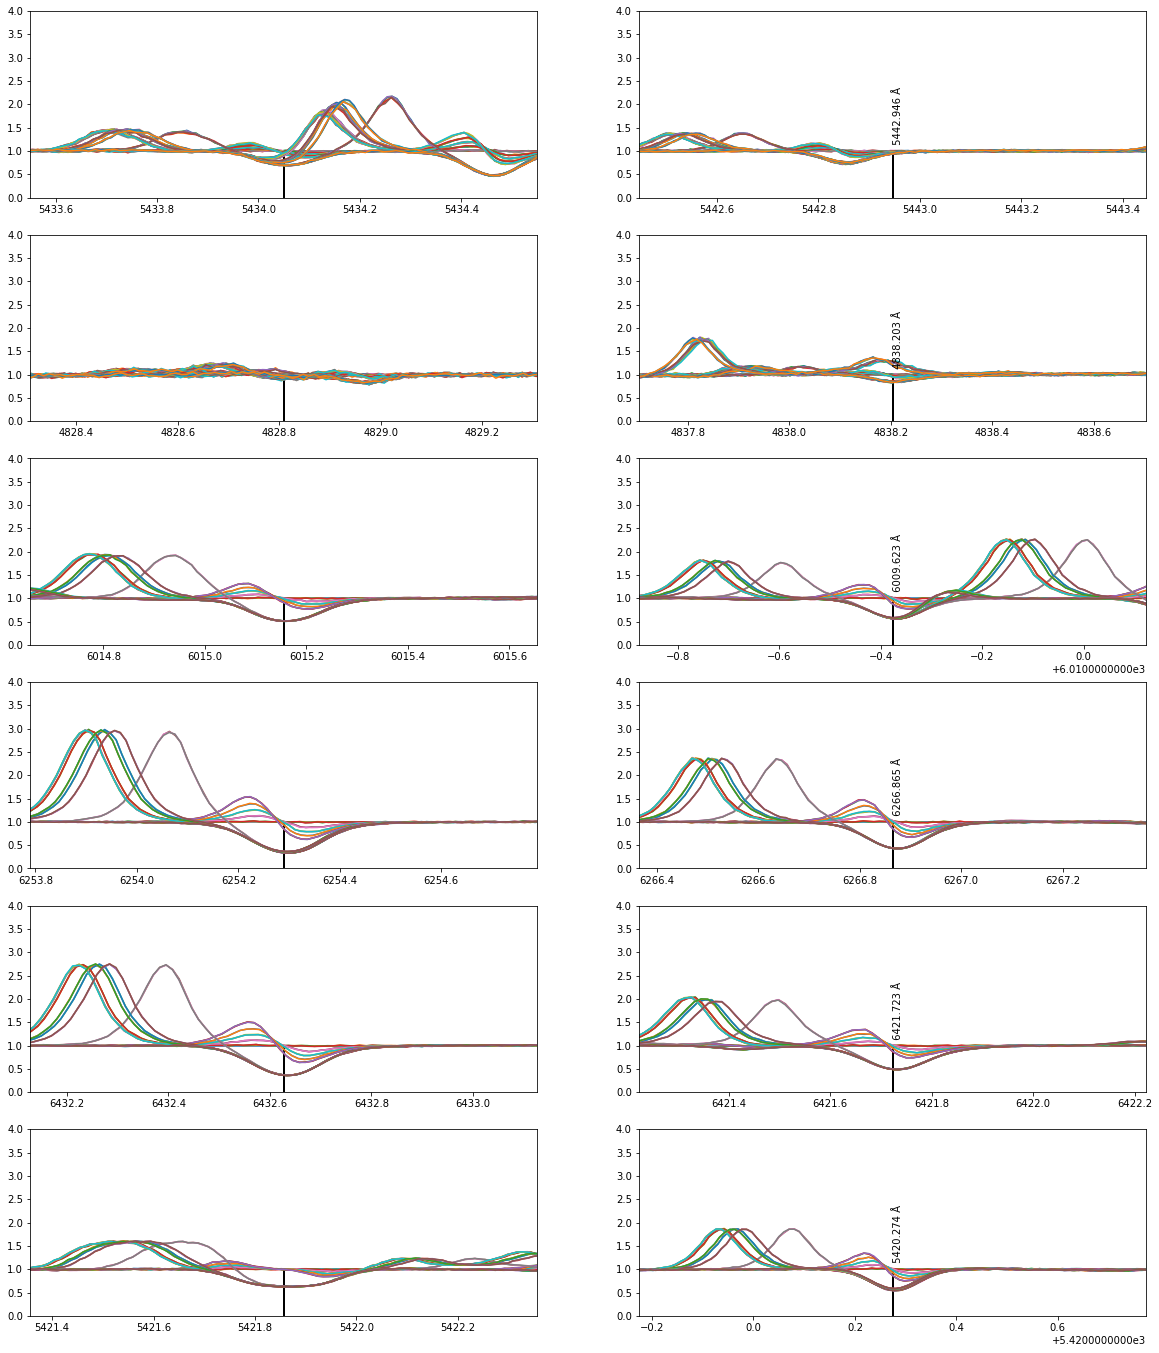

In [7]:
fig2, axes2 = plt.subplots(chosen_wise_lines['Wavelength'].count(), 2, figsize =(20, 24))

active_lines = chosen_wise_lines.copy()
active_lines['Wavelength'] = active_lines['Wavelength'].apply(air2vac)
inactive_lines = vald_lines[~(vald_lines['WL_vac(A)'].apply(lambda x: round(x, 2))).isin(active_lines['Wavelength'].apply(lambda x: round(x, 2)))]
chosen_inactive_lines_wavelength = [5442.851, 4838.203, 6009.623, 6266.865, 6421.723, 5420.274]
chosen_inactive_lines_list = []

#print(inactive_lines[(inactive_lines['WL_vac(A)'] > 5442.5) & (inactive_lines['WL_vac(A)'] < 5442.9)])
#print(active_lines[(active_lines['Wavelength'] < 5434.1) & (active_lines['Wavelength'] > 5434.0)])

# Plot divisions of active lines against inactive lines
wave_range2 = 1
for ax, (active_line_index, active_line), positions, chosen_inactive_line_wavelength in zip(axes2, active_lines.iterrows(), chosen_wise_lines_positions.values(), chosen_inactive_lines_wavelength):
    # Plot active lines
    active_line_vac = active_line['Wavelength']
    active_lower_xbound = active_line_vac - wave_range2 / 2
    active_upper_xbound = active_line_vac + wave_range2 / 2
    ax[0].set_xlim(active_lower_xbound, active_upper_xbound)
    ax[0].set_ylim(0, 4)
    for ind_file, order in positions:
        ax[0].plot(wavelengths[ind_file][order], obs[ind_file][order] / obs[0][order])
        ax[0].vlines(active_line_vac, 0, 1, 'black')
    
    # Plot inactive lines
    depth_range2 = 0.6
    inactive_lower_depth = 0.206 - depth_range2
    inactive_upper_depth = 0.206 + depth_range2
    inactive_lines_depth_filter = (inactive_lines['Central depth'] >= inactive_lower_depth) & (inactive_lines['Central depth'] <= inactive_upper_depth)
    inactive_lines_range_filter = (inactive_lines['WL_vac(A)'] > chosen_inactive_line_wavelength - 0.1) & (inactive_lines['WL_vac(A)'] < chosen_inactive_line_wavelength + 0.1)

    inactive_line_vac_array = inactive_lines[(inactive_lines_depth_filter) & inactive_lines_range_filter]
    chosen_inactive_lines_list.append(inactive_line_vac_array.iloc[-1])
    
    inactive_line_vac = inactive_line_vac_array['WL_vac(A)'].values[-1]
    inactive_lower_xbound = inactive_line_vac - wave_range2 / 2
    inactive_upper_xbound = inactive_line_vac + wave_range2 / 2
    ax[1].set_xlim(inactive_lower_xbound, inactive_upper_xbound)
    ax[1].set_ylim(0, 4)
    for ind_file, order in positions:
        ax[1].plot(wavelengths[ind_file][order], obs[ind_file][order] / obs[0][order])
        ax[1].vlines(inactive_line_vac, 0, 1, 'black')
    ax[1].annotate(f" {inactive_line_vac:.3f} \u00C5", (inactive_line_vac, 1), xytext=(0, 5), textcoords='offset pixels', rotation=90)

import pandas as pd
chosen_inactive_lines = pd.concat(chosen_inactive_lines_list, axis=1)
print(type(chosen_inactive_lines))
print(chosen_inactive_lines)
plt.show()


ASTR  899-03   (9498)
INDEPENDENT STUDY
341334


## Bisector
- [ ] Povich
- [x] Bisector midpoints
- [ ] Fixing velocity offset above
  - [ ] cross correlation, then align
  - [ ] excal 'wave'
- [ ] velocity span from bisector

- [ ] Activity indicators
expres/extracted/activity
one file contains all activity indicators

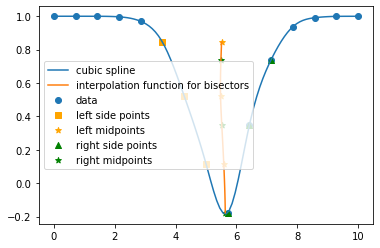

ValueError: A value in x_new is above the interpolation range.

In [9]:
%reload_ext autoreload

from bisector import Bisector
import pandas as pd
bis = Bisector()
bis.plot()

wave_range3 = 0.5
for (active_line_index, active_line), positions, chosen_inactive_line_wavelength in zip(active_lines.iterrows(), chosen_wise_lines_positions.values(), chosen_inactive_lines_wavelength):
    # Plot active lines
    active_line_vac = active_line['Wavelength']
    active_lower_xbound = active_line_vac - wave_range3 / 2
    active_upper_xbound = active_line_vac + wave_range3 / 2
    
    for ind_file, order in positions:
        wave_filter = (wavelengths[ind_file][order] >= active_lower_xbound) & (wavelengths[ind_file][order] <= active_upper_xbound)
        line_bis_active = Bisector(wavelengths[ind_file][order][wave_filter], obs[ind_file][order][wave_filter] / obs[0][order][wave_filter])
        line_bis_active.plot()

activity_34411 = pd.read_csv('activity/34411_activity.csv')
#print(activity_34411)
# notes:
# 1. Write questions to ask Dr. Brewer


## Activity indicators
/stars/expres/extracted/activity/34411_activity.csv

compare with what i did

In [ ]:
with fits.open(loader.filepaths[0]) as hdu:
    print(hdu[1].header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =               799922 / length of dimension 1                          NAXIS2  =                   86 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   17 / number of table fields                         EXTNAME = 'optimal '           / Extraction algorithm                           DATE-EXT= '2021-06-04T17:44:52.160' / Date and time of extraction               SCATLGHT=                    T / Scattered light removed before extraction      EXT_SIZE=                   33 / Size of the extraction window (pixels)         FLAT_REL=                    T / Flat re

('VERSION', 'ID', 'TEFF', 'GRAV', 'FEH', 'VMIC', 'VMAC', 'VSINI', 'VRAD', 'VRAD_FLAG', 'CSCALE', 'CSCALE_FLAG', 'GAM6', 'H2BROAD', 'ACCWI', 'ACCRT', 'CLIM', 'MAXITER', 'CHIRAT', 'NMU', 'NSEG', 'ABUND', 'SPECIES', 'ATOMIC', 'LANDE', 'DEPTH', 'LINEREF', 'SHORT_LINE_FORMAT', 'WRAN', 'MU', 'ATMO', 'WAVE', 'WIND', 'SOB', 'UOB', 'MOB', 'OBS_NAME', 'OBS_TYPE', 'CINTB', 'CINTR', 'VMAC_PRO', 'SMOD', 'CMOD', 'JINT', 'WINT', 'SINT')


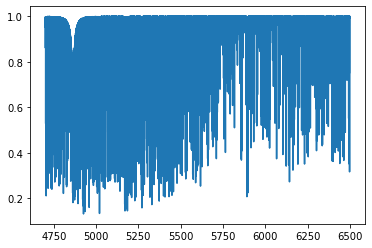

In [ ]:
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.io import readsav

sme_out = readsav('sme/hd34411_4700_6500/hd34411_4700_6500.out', python_dict=False)
print(sme_out['sme'].dtype.names)

plt.figure()
plt.plot(sme_out['sme']['WAVE'][0], sme_out['sme']['SMOD'][0])